<a href="https://colab.research.google.com/github/JaynilJaiswal/siamese_network/blob/master/mnist_siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
cuda = torch.cuda.is_available() # True if cuda is available, False otherwise
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
print('Training on %s' % ('GPU' if cuda else 'CPU'))


Training on GPU


In [3]:
train_data = torchvision.datasets.MNIST(root='../data/', train=True, download=True)
test_data = torchvision.datasets.MNIST(root='../data/', train=False, download=True)

0it [00:00, ?it/s]

9920512it [00:05, 1814215.55it/s]                             


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 327206.78it/s]
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5755619.61it/s]                           
8192it [00:00, 129085.08it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def make_pairs(data, labels, num=1000):
#     print (labels)
    digits = {}
    keys  = range(0,10)
    for i in keys:
      digits[i]=[]
#     print(digits[1])
    for i, j in enumerate(labels):
#         print (i,j.item()) 
        digits[j.item()].append(int(i))
#     l=(0)
#     print(digits)
    pairs, labels_ = [], []
    for i in range(int(num*0.5)):
#         if np.random.rand() >= .5: # same digit
          digit = np.random.choice(range(10))
          d1 = np.random.choice(digits[digit][:])
          d2 = np.random.choice(digits[digit][:])
          labels_.append(1)
          pairs.append(torch.cat([data[d1], data[d2]]).view(1, 56, 28))

#         else:
    for i in range(int(num*0.5)):
          digit1 = np.random.choice(range(10))
          if digit1!=9:
            digit2 = digit1 + 1
          else:
            digit2=digit - 1
          d1 = np.random.choice(digits[digit1])
          d2 = np.random.choice(digits[digit2])
          labels_.append(0)
          pairs.append(torch.cat([data[d1], data[d2]]).view(1, 56, 28))
    return torch.cat(pairs), torch.LongTensor(labels_)

In [32]:
batch = 100

pairs_train, labels_train = make_pairs(train_data.train_data, train_data.train_labels, num=60000)
pairs_test, labels_test = make_pairs(test_data.test_data, test_data.test_labels, num=10000)

train = torch.utils.data.dataset.TensorDataset(pairs_train, labels_train)
test = torch.utils.data.dataset.TensorDataset(pairs_test, labels_test)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
net = torch.nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.PReLU(512),
        nn.BatchNorm1d(512),
        nn.Linear(512, 512),
        nn.PReLU(512),
        nn.BatchNorm1d(512),
        nn.Linear(512, 2)) # 2 = size of the representation (we choose 2 for visualization)


bottom_net = torch.nn.Sequential(
        nn.Linear(2, 32),
        nn.PReLU(32),
        nn.Linear(32, 2))

net = net.type(FloatTensor)
bottom_net = bottom_net.type(FloatTensor)

In [0]:
params = [x for x in net.parameters()] + [x for x in bottom_net.parameters()]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=params, lr=0.001)


In [35]:
epochs = 5
train_size = int(labels_train.size()[0])
test_size = int(labels_test.size()[0])
accuracy = 0.

for i in range(epochs):
    # train network
    for j, (images, labels) in enumerate(train_loader):
        net.train()
        bottom_net.train()
        
        i1, i2 = images.view(batch, -1).split(28 * 28, dim=1)
        i1 = Variable(i1.type(FloatTensor))
        i2 = Variable(i2.type(FloatTensor))
        labels = Variable(labels).type(LongTensor)

        net.zero_grad()
        bottom_net.zero_grad()
        output1 = net(i1)
        output2 = net(i2)
        output = bottom_net((output1 - output2) ** 2)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
            
        # test network
        if (j + 1) % 600 == 0:
            net.eval()
            bottom_net.eval()
            for k, (images, labels) in enumerate(test_loader):
                i1, i2 = images.view(batch, -1).split(28 * 28, dim=1)
                i1 = Variable(i1.type(FloatTensor))
                i2 = Variable(i2.type(FloatTensor))
                labels = Variable(labels).type(LongTensor)
                output1 = net(i1)
                output2 = net(i2)
                output = bottom_net((output1 - output2) ** 2)
                _, predicted = torch.max(output, 1)
                equality= predicted == labels
#                 print(torch.sum(equality).it)
                accuracy += torch.sum(equality).item() / test_size
#                 accuracy += torch.sum(torch.eq(predicted, labels)).data[0].item() / test_size
            print('[TEST] Epoch %i/%i [step %i/%i] accuracy: %.3f' % (i + 1, epochs, j + 1, train_size / batch, accuracy))
            accuracy = 0.


[TEST] Epoch 1/5 [step 600/600] accuracy: 0.971
[TEST] Epoch 2/5 [step 600/600] accuracy: 0.978
[TEST] Epoch 3/5 [step 600/600] accuracy: 0.977
[TEST] Epoch 4/5 [step 600/600] accuracy: 0.983
[TEST] Epoch 5/5 [step 600/600] accuracy: 0.982


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


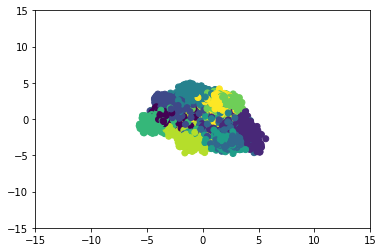

In [36]:
images = Variable(test_data.test_data).view(test_size, 28 * 28).type(FloatTensor)
labels = test_data.test_labels.numpy()
embedding = net(images).data.cpu().numpy()
plt.scatter(*zip(*embedding), c=labels)
plt.xlim(-15, 15)
plt.ylim(-15, 15);


In [0]:
# 